# This notebook demonstrates how to do inference with LogicLLaMA and parse the text FOL rule into a syntax tree that can be used elsewhere

In [19]:
import torch
from functools import partial
from transformers import GenerationConfig, LlamaForCausalLM, LlamaTokenizer
from peft import PeftModel, prepare_model_for_int8_training
from utils import TranslationDataPreparer, ContinuousCorrectionDataPreparer, make_parent_dirs
from fol_parser import parse_text_FOL_to_tree
from generate import llama_generate

In [12]:
base_model='path/to/llama-7b' # TODO: fill in with the path to the llama-7b model
prompt_template_path='data/prompt_templates'
load_in_8bit = True
max_output_len = 128

In [8]:
tokenizer = LlamaTokenizer.from_pretrained(base_model)
tokenizer.add_special_tokens({
    "eos_token": "</s>",
    "bos_token": "<s>",
    "unk_token": '<unk>',
    "pad_token": '<unk>',
})
tokenizer.padding_side = "left"  # Allow batched inference

generation_config = GenerationConfig(
    temperature=0.1,
    top_p=0.75,
    top_k=40,
    num_beams=1
)

llama_model = LlamaForCausalLM.from_pretrained(
    base_model,
    load_in_8bit=load_in_8bit,
    torch_dtype=torch.float16,
    device_map='auto',
)
llama_model = prepare_model_for_int8_training(llama_model)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.
This model has some weights that should be kept in higher precision, you need to upgrade `accelerate` to properly deal with them (`pip install --upgrade accelerate`).


Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

# LogicLLaMA Translation

In [9]:
peft_path='yuan-yang/LogicLLaMA-7b-direct-translate-delta-v0'

In [11]:
model = PeftModel.from_pretrained(
    llama_model,
    peft_path,
    torch_dtype=torch.float16
)
model.to('cuda')

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=31999)
        (layers): ModuleList(
          (0): LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear8bitLt(
                in_features=4096, out_features=4096, bias=False
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): Linear8bitLt(
                in_features=4096, out_features=4096, bias=Fals

In [18]:
data_preparer = TranslationDataPreparer(
    prompt_template_path,
    tokenizer,
    False,
    256 # just a filler number
)

prepare_input = partial(
    data_preparer.prepare_input,
    **{"nl_key": "NL"},
    add_eos_token=False,
    eval_mode=True,
    return_tensors='pt'
)

simple_generate = partial(
    llama_generate,
    llama_model=model,
    data_preparer=data_preparer,
    max_new_tokens=max_output_len,
    generation_config=generation_config,
    prepare_input=prepare_input,
    return_tensors=False
)

## You can try your own sentences

In [21]:
data_point = {'NL': 'The one who created this repo is either a human or an alien'}

In [22]:
full_resp_str, resp_parts = simple_generate(input_str=data_point)

/home/yuan/anaconda3/envs/nlp-ilp/lib/python3.7/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


In [23]:
resp_parts

['N/A\n\n', '∃x (Created(x, y) ∧ Repo(y) ∧ (Human(x) ∨ Alien(x)))']

In [25]:
rule_str = resp_parts[1]
rule_str

'∃x (Created(x, y) ∧ Repo(y) ∧ (Human(x) ∨ Alien(x)))'

## You can parse the text FOL rule into FOL tree

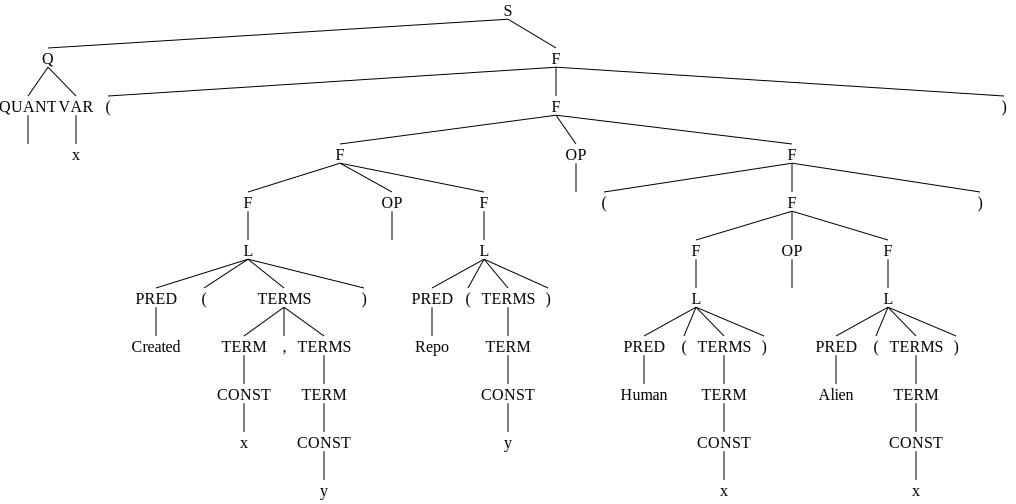

In [26]:
tree = parse_text_FOL_to_tree(rule_str)
tree

# LogicLLaMA Correction

In [29]:
peft_path='yuan-yang/LogicLLaMA-7b-naive-correction-delta-v0'

In [30]:
model = PeftModel.from_pretrained(
    llama_model,
    peft_path,
    torch_dtype=torch.float16
)
model.to('cuda')

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=31999)
        (layers): ModuleList(
          (0): LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear8bitLt(
                in_features=4096, out_features=4096, bias=False
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): Linear8bitLt(
                in_features=4096, out_features=4096, bias=Fals

In [32]:
data_preparer = ContinuousCorrectionDataPreparer(
    prompt_template_path,
    tokenizer,
    False,
    256 # just a filler number
)

prepare_input = partial(
    data_preparer.prepare_input,
    **{"nl_key": "NL", "pred_fol_key": "Pred FOL"},
    add_eos_token=False,
    eval_mode=True,
    return_tensors='pt'
)

simple_generate = partial(
    llama_generate,
    llama_model=model,
    data_preparer=data_preparer,
    max_new_tokens=max_output_len,
    generation_config=generation_config,
    prepare_input=prepare_input,
    return_tensors=False
)

In [33]:
data_point = {
    'NL': 'The one who created this repo is either a human or an alien',
    'Pred FOL': 'Created(x, y) ∧ Repo(y) ∧ Human(x)'
}

In [34]:
full_resp_str, resp_parts = simple_generate(input_str=data_point)

In [35]:
rule_str = resp_parts[1]
rule_str

'CreatedBy(repo, human) ⊕ CreatedBy(repo, alien)'

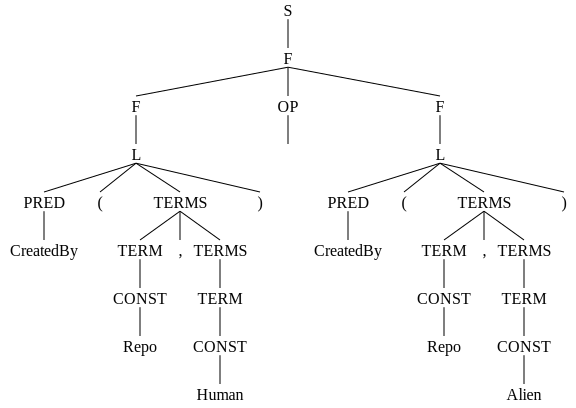

In [36]:
tree = parse_text_FOL_to_tree(rule_str)
tree